In [1]:
import sys, h5py, pdb,time, glob, os
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from scipy import interpolate
from matplotlib import ticker, patches
sys.path.append('/mnt/home/jstern/gizmo_analysis/pysrc/')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'
import matplotlib.image as mpimg

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = '/mnt/home/jstern/cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
import TwoDsolution
reload(CF); reload(TwoDsolution)

<module 'TwoDsolution' from '/mnt/home/jstern/cooling_flow/pysrc/TwoDsolution.py'>

In [5]:
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e3_n10_NoLowCool'
#simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
#vc = 200. *un.km/un.s
#Rcirc = 10.*un.kpc
#snapshot_dt_Myr = 10

In [6]:
simname = 'vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3'
vc = 200. *un.km/un.s
Rcirc = 15.*un.kpc
snapshot_dt_Myr = 50


In [7]:
simdir = wd.simdir+'/%s/output/'%simname
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function
print(sim.galaxyname, sim.Nsnapshots())

vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3 72


# hot gas profile plot

In [8]:
iSnapshots = range(61,72,5)
theta_means = np.array([0.,1/4.,0.485])[-1:]*np.pi
r_bins = 10.**np.linspace(0,2.1,200); mid_bins_r = (r_bins[1:]+r_bins[:-1])/2
_hist_Ts, _hist_ns, _hist_Ps, _hist_Omegas = [np.zeros((len(iSnapshots),len(theta_means),len(r_bins)-1)) for _ in range(4)]
for i,iSnapshot in enumerate(iSnapshots):
    print(iSnapshot)
    snapshot = sim.getSnapshot(iSnapshot)
    xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
    zs += 0.25 #disk is offset for some reason
    phis = np.arctan2(ys,xs)
    Rs = (xs**2+ys**2)**0.5
    rs = (Rs**2+zs**2)**0.5
    thetas = np.arccos(zs/rs)
    for itheta,theta in enumerate(theta_means):
        inds = (thetas>theta-0.005*np.pi) & (thetas<theta+0.005*np.pi)
        _hist_Ts[i,itheta,:]    ,_,bin_inds = scipy.stats.binned_statistic(rs[inds],snapshot.Ts()[inds],        statistic='mean',bins=r_bins)  
        _hist_ns[i,itheta,:]    ,_,bin_inds = scipy.stats.binned_statistic(rs[inds],snapshot.nHs()[inds],        statistic='mean',bins=r_bins)  
        _hist_Ps[i,itheta,:]    ,_,bin_inds = scipy.stats.binned_statistic(rs[inds],(CF.mu*CF.X)**-1*snapshot.nHTs()[inds],statistic='mean',bins=r_bins)  
        _hist_Omegas[i,itheta,:],_,bin_inds = scipy.stats.binned_statistic(rs[inds],snapshot.v_phi()[inds]/Rs[inds],statistic='mean',bins=r_bins)  
    

61


/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:341: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


66
71


In [9]:
hist_Ts3, hist_ns3, hist_Ps3, hist_Omegas3 = [np.mean(x,axis=0) for x in (_hist_Ts, _hist_ns, _hist_Ps, _hist_Omegas)]

In [10]:
import TwoDsolution
reload(CF); reload(TwoDsolution)

<module 'TwoDsolution' from '/mnt/home/jstern/cooling_flow/pysrc/TwoDsolution.py'>

In [11]:
vc = 203 * un.km/un.s
Mdot = 1 * un.Msun/un.yr
Lambda = ff.LambdaFunc(0)(2e6*(vc.value/200)**2,0.1,0.3)*un.erg/un.s*un.cm**3
radial = TwoDsolution.ZeroOrder(Mdot,vc,Lambda)
anal = TwoDsolution.FirstOrder(Mdot,vc,Lambda,Rcirc)

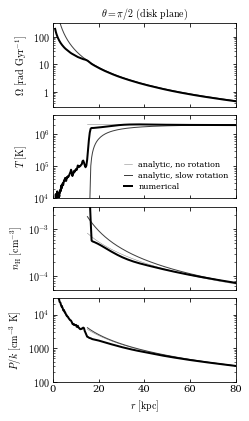

In [12]:
fig = pl.figure(figsize=(fig_width_half,6))        
gs2 = gridspec.GridSpec(4,1,left=0.15,wspace=0.1,hspace=0.1,bottom=0.05)
for i in range(4):    
    attr = ('Omegas','Ts','nHs','P2ks','Ks')[i]    
    ys  = (hist_Omegas3, hist_Ts3, hist_ns3, hist_Ps3)[i]
    yls = ((0.3,300),(1e4,0.4e7),(5e-5,0.003),(100,3e4))[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$T\ [{\rm K}]$',
             r'$n_{\rm H}\ [{\rm cm}^{-3}]$',r'$P/k\ [{\rm cm}^{-3}\ {\rm K}]$',
            r'$K\ [{\rm keV}\ {\rm cm}^2]$')[i]
    for itheta,theta in enumerate(theta_means):
        ind = np.searchsorted(anal.thetas()[:,0],theta)
        ind2 = (np.searchsorted(anal.Rs()[0,:],Rcirc),0)[i==0]
        ax = fig.add_subplot(gs2[i,itheta]); spec = ax.get_subplotspec()
        order1 = getattr(anal, attr)()[ind,:]
        order0 = getattr(radial, attr)()[:].value
        pl.plot(radial.Rs()[ind2:], order0[ind2:],c='.5',  lw=0.5, label='analytic, no rotation')
        pl.plot(anal.Rs()[ind,ind2:],   order1[ind2:],c='.25', lw=1,   label='analytic, slow rotation')
        pl.plot(mid_bins_r[1:-1],ys[itheta][1:-1], c='k',lw=2,label=r'numerical')
        pl.semilogy()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
        ax.yaxis.set_major_formatter(ff.u.arilogformatter)        
        ax.yaxis.set_major_locator(ticker.LogLocator(numdecs=5,numticks=10))   
        if spec.is_last_row(): pl.xlabel(r'$r\ [{\rm kpc}]$')
        else: ax.xaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_col(): pl.ylabel(label)
        else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_row():
            pl.title(r'$\theta=\pi/2\ ({\rm disk\ plane})$',fontsize=10)
        if i==1:
            pl.legend(loc='lower right',frameon=False,handlelength=1,fontsize=8,labelspacing=0.4)
        pl.ylim(*yls)        
        pl.xlim(0,80)
pl.savefig(figdir+'comparison_to_analytic_vs_r.pdf',bbox_inches='tight')

In [13]:
snapshot = sim.getSnapshot(71)
xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
zs += 0.25 #disk is offset for some reason
phis = np.arctan2(ys,xs)
Rs = (xs**2+ys**2)**0.5
rs = (Rs**2+zs**2)**0.5
thetas = np.arccos(zs/rs)

In [14]:
r=45
theta_bins = np.linspace(0,np.pi,100); mid_bins = (theta_bins[1:]+theta_bins[:-1])/2
inds = (rs>r-1) & (rs<r+1)
hist_Ts,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],snapshot.Ts()[inds],        statistic='mean',bins=theta_bins)  
hist_ns,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],snapshot.nHs()[inds],        statistic='mean',bins=theta_bins)  
hist_Ps,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],(CF.mu*CF.X)**-1*snapshot.nHTs()[inds],        statistic='mean',bins=theta_bins)  
hist_Ks,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],snapshot.Ks()[inds],        statistic='mean',bins=theta_bins)  
hist_Lxs,_,bin_inds    = scipy.stats.binned_statistic(thetas[inds],snapshot.rad_per_unit_volume()[inds],statistic='mean',bins=theta_bins)  
hist_Omegas,_,bin_inds = scipy.stats.binned_statistic(thetas[inds],snapshot.v_phi()[inds]/Rs[inds],statistic='mean',bins=theta_bins)  
hist_vthetas,_,bin_inds = scipy.stats.binned_statistic(thetas[inds],snapshot.v_theta()[inds],statistic='mean',bins=theta_bins)  
hist_vrs,_,bin_inds = scipy.stats.binned_statistic(thetas[inds],snapshot.vrs()[inds],statistic='mean',bins=theta_bins)  

/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:341: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))
/mnt/home/jstern/gizmo_analysis/pysrc/FIRE_files.py:347: RuntimeWarning: invalid value encountered in multiply
  vtheta2 *= vtheta2>0 #avoid nans


In [15]:
r2=25
inds2 = (rs>r2-1) & (rs<r2+1)
hist_Ts2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],snapshot.Ts()[inds2],        statistic='mean',bins=theta_bins)  
hist_ns2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],snapshot.nHs()[inds2],        statistic='mean',bins=theta_bins)  
hist_Ps2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],(CF.mu*CF.X)**-1*snapshot.nHTs()[inds2],        statistic='mean',bins=theta_bins)  
hist_Ks2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],snapshot.Ks()[inds2],        statistic='mean',bins=theta_bins)  
hist_Lxs2,_,bin_inds    = scipy.stats.binned_statistic(thetas[inds2],snapshot.rad_per_unit_volume()[inds2],statistic='mean',bins=theta_bins)  
hist_Omegas2,_,bin_inds = scipy.stats.binned_statistic(thetas[inds2],snapshot.v_phi()[inds2]/Rs[inds2],statistic='mean',bins=theta_bins)  

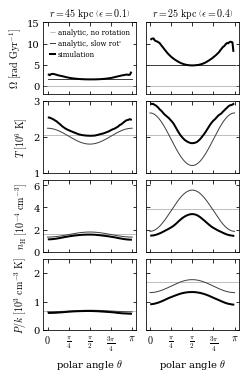

In [34]:
fig = pl.figure(figsize=(fig_width_half,5)); 
gs  = gridspec.GridSpec(4,2,wspace=0.1,hspace=0.1,right=0.9,left=0.1,bottom=0.025)
for i in range(4):    
    norm = (1,1e6,1e-4,1e3,1)[i]
    ys  = (hist_Omegas,  hist_Ts,  hist_ns,  hist_Ps,  hist_Ks)[i]
    ys2 = (hist_Omegas2, hist_Ts2, hist_ns2, hist_Ps2, hist_Ks2)[i]
    attr = ('Omegas','Ts','nHs','P2ks','Ks')[i]    
    yls = ((-2,15),(1,3),(0,6.5),(0,2.5),(0,30))[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$T\ [10^6\ {\rm K}]$',
             r'$n_{\rm H}\ [10^{-4}\ {\rm cm}^{-3}]$',r'$P/k\ [10^3\ {\rm cm}^{-3}\ {\rm K}]$',
            r'$K\ [{\rm keV}\ {\rm cm}^2]$')[i]
    for ir,_r in enumerate((r,r2)):
        ind = np.searchsorted(radial.Rs().value,_r)
        ax = fig.add_subplot(gs[i,ir]); spec = ax.get_subplotspec()
        order1 = getattr(anal, attr)()[:,ind]
        order0 = getattr(radial, attr)()[ind].value
        pl.axhline(order0/norm,c='.5',lw=0.5,label='analytic, no rotation')
        pl.plot(anal.thetas()[:,ind],order1/norm,c='.25',lw=1,label="analytic, slow rot'")
        pl.plot(mid_bins[1:-1],(ys,ys2)[ir][1:-1]/norm, c='k',lw=2,label=r'simulation')
        ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi))        
        if spec.is_last_row(): 
            ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))
            pl.xlabel(r'polar angle $\theta$')
        else:
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
        if ir==0: pl.ylabel(label)
        else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_row(): 
            pl.title(r'$r=%d\ {\rm kpc}\ \left(\epsilon=%.1f\right)$'%(_r,(_r/Rcirc.value)**-2),fontsize=10)
            if ir==0: pl.legend(loc='upper left',frameon=False,handlelength=0.7,fontsize=7,labelspacing=0.4,handletextpad=0.5)
        if i==0: ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  
        if i==2: ax.yaxis.set_major_locator(ticker.MultipleLocator(2))  
        pl.ylim(*yls) 
pl.savefig(figdir+'comparison_to_analytic_vs_theta.pdf',bbox_inches='tight')

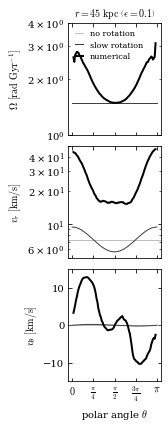

In [236]:
fig = pl.figure(figsize=(fig_width_half,6)); 
gs  = gridspec.GridSpec(3,2,wspace=0.1,hspace=0.1,right=0.9,left=0.1,bottom=0.05)
for i in range(3):    
    norm = 1#(1,1e6,1e-4,1e3,1)[i]
    ys  = (hist_Omegas,  -hist_vrs,  hist_vthetas)[i]
    attr = ('Omegas','vrs','vthetas')[i]    
    yls = ((1,4),(5,50),(-15,15))[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$v_r\ [{\rm km/s}]$',
             r'$v_{\theta}\ [{\rm km/s}]$')[i]
    for ir,_r in enumerate((r,r2)[:1]):
        ind = np.searchsorted(radial.Rs().value,_r)
        ax = fig.add_subplot(gs[i,ir]); spec = ax.get_subplotspec()
        order1 = getattr(anal, attr)()[:,ind]
        order0 = getattr(radial, attr)()[ind].value
        pl.axhline(order0/norm,c='.5',lw=0.5,label='no rotation')
        pl.plot(anal.thetas()[:,ind],order1/norm,c='.25',lw=1,label='slow rotation')
        pl.plot(mid_bins[1:-1],(ys,ys2)[ir][1:-1]/norm, c='k',lw=2,label=r'numerical')
        ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi))        
        if spec.is_last_row(): 
            ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))
            pl.xlabel(r'polar angle $\theta$')
        else:
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
        if ir==0: pl.ylabel(label)
        else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_row(): pl.title(r'$r=%d\ {\rm kpc}\ \left(\epsilon=%.1f\right)$'%(_r,(_r/Rcirc.value)**-2),fontsize=10)
        if ir==0 and i==0:
            pl.legend(loc='upper left',frameon=False,handlelength=1,fontsize=8,labelspacing=0.4)
        pl.ylim(*yls) 
        if i<2: pl.semilogy()

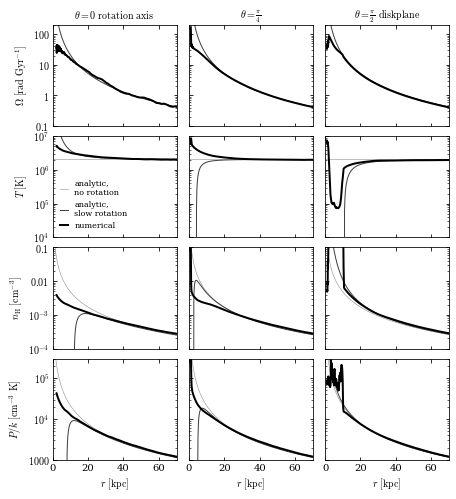

In [52]:
fig = pl.figure(figsize=(fig_width_full,8)); pl.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(4):    
    norm = (1,1e6,1e-4,1e3,1)[i]
    ys  = (hist_Omegas, hist_Ts, hist_ns, hist_Ps)[i]
    attr = ('Omegas','Ts','nHs','P2ks')[i]    
    yls = ((0.1,200),(1e4,1e7),(1e-4,0.1),(1000,3e5))[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$T\ [{\rm K}]$',
             r'$n_{\rm H}\ [{\rm cm}^{-3}]$',r'$P/k\ [{\rm cm}^{-3}\ {\rm K}]$',
            r'$K\ [{\rm keV}\ {\rm cm}^2]$')[i]
    for itheta,theta in enumerate(theta_means):
        ind = np.searchsorted(anal.thetas()[:,0],theta)
        ax = pl.subplot(4,len(theta_means),itheta+i*len(theta_means)+1); spec = ax.get_subplotspec()
        order1 = getattr(anal, attr)()[ind,:]
        order0 = getattr(radial, attr)()[:].value
        pl.plot(radial.Rs(), order0,c='.5',  lw=0.5, label='analytic,\nno rotation')
        pl.plot(anal.Rs()[ind,:],   order1,c='.25', lw=1,   label='analytic,\nslow rotation')
        pl.plot(mid_bins[1:-1],ys[itheta][1:-1], c='k',lw=2,label=r'numerical')
        pl.semilogy()
        ax.yaxis.set_major_formatter(ff.u.arilogformatter)        
        if spec.is_last_row():             
            pl.xlabel(r'$r\ [{\rm kpc}]$')
        else:
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_col(): pl.ylabel(label)
        else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_row():
            tit = [r'$\theta=0\ {\rm rotation\ axis}$',
                   r'$\theta=\frac{\pi}{4}$',
                   r'$\theta=\frac{\pi}{2}\ {\rm disk plane}$'][itheta]
            pl.title(tit,fontsize=10)
        if itheta==0 and i==1: pl.legend(loc='lower left',frameon=False,handlelength=1,fontsize=8)
        pl.ylim(*yls)        
        pl.xlim(0,70)
#pl.savefig(figdir+'comparison_to_analytic_by_r.pdf',bbox_inches='tight')

/tmp/ipykernel_2178850/1395741204.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))
/tmp/ipykernel_2178850/1395741204.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))


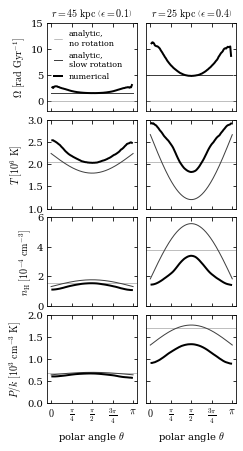

In [29]:
fig = pl.figure(figsize=(fig_width_half,7)); pl.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(4):    
    norm = (1,1e6,1e-4,1e3,1)[i]
    ys  = (hist_Omegas, hist_Ts, hist_ns, hist_Ps,hist_Ks)[i]
    ys2 = (hist_Omegas2, hist_Ts2, hist_ns2, hist_Ps2,hist_Ks2)[i]
    attr = ('Omegas','Ts','nHs','P2ks','Ks')[i]    
    yls = ((-2,15),(1,3),(0,6),(0,2),(0,30))[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$T\ [10^6\ {\rm K}]$',
             r'$n_{\rm H}\ [10^{-4}\ {\rm cm}^{-3}]$',r'$P/k\ [10^3\ {\rm cm}^{-3}\ {\rm K}]$',
            r'$K\ [{\rm keV}\ {\rm cm}^2]$')[i]
    for ir,_r in enumerate((r,r2)):
        ind = np.searchsorted(radial.Rs().value,_r)
        ax = pl.subplot(4,2,ir+i*2+1); spec = ax.get_subplotspec()
        order1 = getattr(anal, attr)()[:,ind]
        order0 = getattr(radial, attr)()[ind].value
        pl.axhline(order0/norm,c='.5',lw=0.5,label='analytic,\nno rotation')
        pl.plot(anal.thetas()[:,ind],order1/norm,c='.25',lw=1,label='analytic,\nslow rotation')
        pl.plot(mid_bins[1:-1],(ys,ys2)[ir][1:-1]/norm, c='k',lw=2,label=r'numerical')
        if spec.is_last_row(): 
            ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']))
            pl.xlabel(r'polar angle $\theta$')
        else:
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_col(): pl.ylabel(label)
        else: ax.yaxis.set_major_formatter(ticker.NullFormatter())
        if spec.is_first_row():
            pl.title(r'$r=%d\ {\rm kpc}\ \left(\epsilon=%.1f\right)$'%(_r,(_r/Rcirc.value)**-2),fontsize=10)
            if ir==0: pl.legend(loc='upper left',frameon=False,handlelength=1,fontsize=8)
        ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi))        
        pl.ylim(*yls)        
pl.savefig(figdir+'comparison_to_analytic.pdf',bbox_inches='tight')

# unknown plot

In [10]:
inds = (snapshot.Ts()<4e5) & (snapshot.Ts()>2e5) & (Rs>8) & (Rs<10)

NameError: name 'Rs' is not defined

In [ ]:
nHs = snapshot.nHs()
tcools = snapshot.t_cool()

In [30]:
js = np.array([coords[:,1] * vs[:,2] - coords[:,2] * vs[:,1],
               coords[:,2] * vs[:,0] - coords[:,0] * vs[:,2],
               coords[:,0] * vs[:,1] - coords[:,1] * vs[:,0]])
js=js.T
jzs = js[:,2]

In [31]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,2]
vRs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs)
vrs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs + vs[:,2]*zs/rs)
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,0]*np.cos(thetas)*np.cos(phis) + vs[:,1]*np.cos(thetas)*np.sin(phis) - vs[:,2]*np.sin(thetas)

$v_\theta$ mean=16.973, std=30.950
$v_r$ mean=-10.770, std=26.731
$v_\phi$ mean=213.642, std=24.410
$v_R$ mean=-10.196, std=26.616
$v_{|z|}$ mean=-17.283, std=31.048


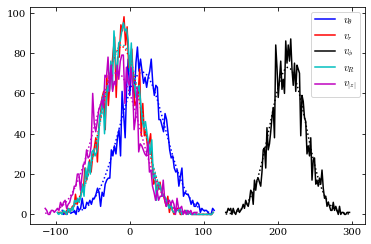

In [129]:
above_plane = (-1)**(zs<0.3)
vspherical = [(vthetas*above_plane)[inds],vrs[inds],vphis[inds],vRs[inds],(above_plane*vzs)[inds]]
for iv,v in enumerate(vspherical):
    c = 'brkcm'[iv]
    label = (r'$v_\theta$',r'$v_r$',r'$v_\phi$',r'$v_R$',r'$v_{|z|}$')[iv]
    a,b=pl.histogram(v,bins=100)
    mean,std = np.mean(v),np.std(v); print(label, 'mean=%.3f, std=%.3f'%(mean,std))
    bb = (b[1:]+b[:-1])/2; db = bb[1]-bb[0]
    pl.plot(bb,a,c=c,label=label)
    pl.plot(bb,scipy.stats.norm.pdf(bb,loc=mean,scale=std)*a.sum()*db,c=c,ls=':')
    pl.legend()

In [46]:
ls =((1e4*un.Msun/(4*np.pi/3*cons.m_p*nHs*un.cm**-3/0.7))**(1/3)).to('kpc')

In [54]:
(ls.to('cm')*nHs*un.cm**-3*ls**2/(2*un.kpc*2*np.pi*9*un.kpc))[inds].sum() * 5e-4*0.2/3

<Quantity 1.62538128e+14 1 / cm2>

In [61]:
np.median(ls[inds])

<Quantity 0.10943618 kpc>

In [60]:
np.median(nHs[inds])*1e-4/3

1.7197967817385993e-06

In [65]:
np.median(tcools[inds])

1.9614762444724372

In [69]:
(10*un.kpc / (200*un.km/un.s)).to('Myr')

<Quantity 48.88961108 Myr>

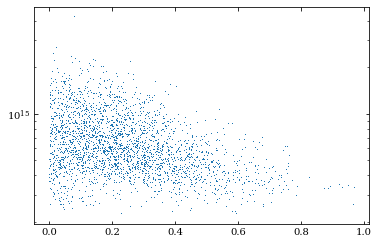

In [124]:
pl.semilogy(np.abs(zs[inds]-0.3),(ls*nHs*un.kpc.to('cm')*1e-4/3)[inds],',')

# verify cooling calculation is similar to that in FIRE

In [100]:
import os, glob
from scipy import interpolate
tables_dir = os.getenv("HOME")+'/github_repositories/gizmo_analysis/CoolingTables/'

def LambdaFile(z):
    fns = np.array(glob.glob(tables_dir+'z_?.???.hdf5'))
    zs = np.array([float(fn[-10:-5]) for fn in fns])
    fn = fns[zs.argsort()][u.searchsortedclosest(sorted(zs), z)]
    print(fn)
    f=h5py.File(fn,'r')
    return f

In [102]:
Zsun = [0.0129,0.2806,2.07e-3,8.36e-4,5.49e-3,1.41e-3,5.91e-4,6.83e-4,4.09e-4,6.44e-5,1.1e-3]

In [103]:
LAMBDA1 = ff.LambdaFunc(0)
print(LAMBDA1(2e6,0.1,0.1))
f = LambdaFile(0)
a = snapshot.dic['PartType0','Metallicity'][inds][0]
FIRE_inds = ['Z','Helium','Carbon','Nitrogen','Oxygen','Neon','Magnesium','Silicon','Sulphur','Calcium','Iron']
iHe = u.searchsortedclosest(f['Metal_free']['Helium_mass_fraction_bins'][:],a[1])
H_He_Cooling  = f['Metal_free']['Net_Cooling'][iHe,...]
Tbins         = f['Metal_free']['Temperature_bins'][...]
nHbins        = f['Metal_free']['Hydrogen_density_bins'][...]
Metal_Cooling = np.sum([f[FIRE_inds[i]]['Net_Cooling'][...]*a[i]/Zsun[i] for i in range(2,11)],axis=0)
f_H_He = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    H_He_Cooling,
                                                    bounds_error=False, fill_value=None)
f_Z    = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    Metal_Cooling,
                                                    bounds_error=False, fill_value=None)
f2 = lambda T,nH,f_H_He=f_H_He,f_Z=f_Z: (
        f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))))
f2(2e6,0.001)


1.4038108602647772e-23
/home/ysz5546/github_repositories/gizmo_analysis/CoolingTables/z_0.000.hdf5


1.3182569998698887e-23

In [173]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-2.1,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_Ts,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='mean',bins=(bins_Rs,bins_zs))  
hist_vzs,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,np.abs(snapshot.vs()[:,2]),statistic='mean',bins=(bins_Rs,bins_zs))  

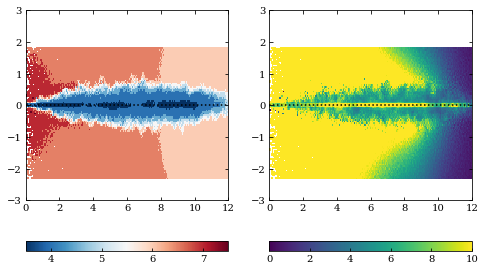

In [180]:
pl.figure(figsize=(8,5))
for iPanel in range(2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,(hist_vzs / (200*30*np.abs(midbins_zs-0.25))**0.5).T,
                             cmap='viridis',zorder=-100,vmax=10,vmin=0) 
    pl.ylim(-3,3); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [60]:
(10**3.5/2e6)**0.5 * 10

0.39763536438352537

In [151]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(0,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_masses,a,b,bin_inds = scipy.stats.binned_statistic_2d(
    np.concatenate([(snapshot.coords(j)[:,:2]**2).sum(axis=1)**0.5 for j in range(6) if j!=1]),
    np.concatenate([np.abs(snapshot.coords(j)[:,2]-0.25) for j in range(6) if j!=1]),
    np.concatenate([snapshot.masses(j) for j in range(6) if j!=1]),
    statistic='sum',bins=(bins_Rs,bins_zs))  

In [152]:
hist_masses.shape,  midbins_zs.shape, midbins_Rs.shape

((259, 42), (42,), (259,))

In [153]:
midbins_Rs_grid,midbins_zs_grid = np.meshgrid(midbins_Rs,midbins_zs)
g_isothermal = (200*un.km/un.s)**2 / (midbins_Rs_grid*un.kpc) * midbins_zs_grid / midbins_Rs_grid

In [154]:
gs = (2*np.pi*cons.G * hist_masses.sum(cumsum(axis=1).T*un.Msun / (0.05*un.kpc)**2).to('km**2*s**-2/kpc')


In [172]:
# gz ~ vc^2
((2*np.pi*cons.G*1e10*un.Msun / (np.pi*(10*un.kpc)**2) * 1*un.kpc)**0.5).to('km/s')

<Quantity 29.3288843 km / s>

In [166]:
np.searchsorted(midbins_Rs,10)

210

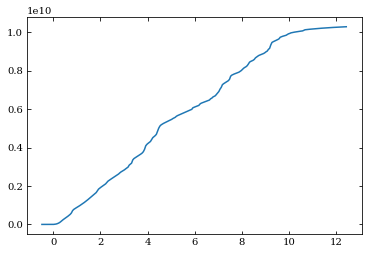

In [169]:
pl.plot(midbins_Rs,hist_masses.cumsum(axis=1).cumsum(axis=0)[:,-1])

In [155]:
#point source: 4pi r^2 g = 4 pi GM 
#plane parallel 2Ag = 4 pi G sigma A -> g = 2 pi G sigma

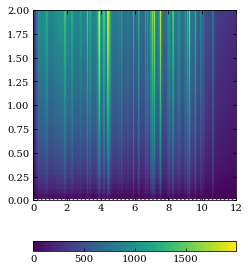

In [157]:
pl.figure(figsize=(8,5))
for iPanel in range(1,2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs,(gs*midbins_zs_grid)**0.5,
                             cmap='viridis',zorder=-100) 
    pl.ylim(0,2); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [103]:
snapshot.dic[('PartType0','Masses')][:100]

array([0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.00590503,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.00590503, 0.00590503, 0.00590503,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590503,
       0.01771542, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
         -89,  -88,  -87,  -86, 

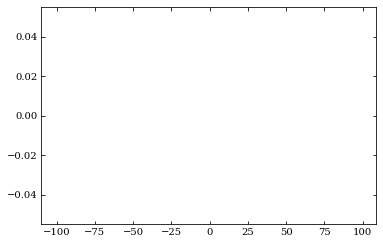

In [92]:
pl.hist(log(snapshot.masses()),bins=np.arange(-100,100))

In [77]:
a=snapshot.dic[('PartType0','Potential')]

KeyError: "Unable to open object (object 'Potential' doesn't exist)"